# SRGAN demonstration for QR code enhancement

Installing dependencies+ Unzipping data

In [ ]:
!unzip archive.zip

Archive:  archive.zip
replace qr_dataset/1002-v1.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [ ]:
!wget https://raw.githubusercontent.com/PsVenom/QR-code-enhancement-using-SRGANs/main/main.py

--2022-04-30 11:43:39--  https://raw.githubusercontent.com/PsVenom/QR-code-enhancement-using-SRGANs/main/main.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8003::154, 2606:50c0:8001::154, 2606:50c0:8000::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8003::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3020 (2.9K) [text/plain]
Saving to: ‘main.py.1’

100%[======================================>] 3,020       --.-K/s   in 0s      

2022-04-30 11:43:39 (17.1 MB/s) - ‘main.py.1’ saved [3020/3020]



In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:
!pip install opencv-python
!pip install tqdm
!pip install scikit-image


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


looking at a single example

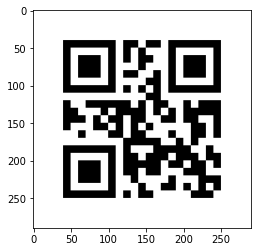

In [ ]:
import cv2 
import os
datadir = 'qr_dataset'
# iterating over just one element
for img in os.listdir(datadir): 
        img_array = cv2.imread(os.path.join(datadir,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
        plt.imshow(img_array, cmap='gray')  # graph it
        plt.show()  # display!

        break  # we just want one for now so break

storing the images

In [ ]:
#generalising this technique for all other images 
array = []
array_small =[]
from tqdm import tqdm
def create_training_data():
        for img in tqdm(list(os.listdir(datadir))):  # iterate over each image per dogs and cats
            try:
                img_array = cv2.imread(datadir+'/'+img ,cv2.IMREAD_COLOR)  # convert to array
                new_array = cv2.resize(img_array, (128, 128))  # resize to normalize data size
                array.append([new_array]) 
                array_small.append([cv2.resize(img_array, (32,32),
                               interpolation=cv2.INTER_AREA)]) # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass
create_training_data()

100%|██████████| 10000/10000 [00:45<00:00, 218.88it/s]


In [ ]:
len(array)

10000

In [ ]:
X = []
Xs = []
for features in array:
    X.append(features)
for features in array_small:
    Xs.append(features)
X = np.array(X).reshape(-1, 128, 128, 3)
Xs = np.array(Xs).reshape(-1, 32, 32, 3)


Image Augmentation (offline)

In [ ]:
#augmenting the data
from keras.preprocessing.image import ImageDataGenerator #this generator will save files in a physical format
from skimage import io
datagen = ImageDataGenerator(        
        rotation_range = 40,
        shear_range = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True,
        brightness_range = (0.5, 1.5))

for a in X:
 i = 0
 a = a.reshape((1, ) + a.shape)
 for batch in datagen.flow(a, batch_size=1,  save_to_dir= 'Augmented-images', save_prefix='dr', save_format='jpeg'):    
  try:
    i += 1   
    if i>= 10:
      break 
  except Exception:
    print("error")
    pass




loading augmented images and adding them to image array

In [ ]:
array=[]
array_small=[]
datadir = 'Augmented-images'
create_training_data()

100%|██████████| 10000/10000 [00:56<00:00, 177.30it/s]


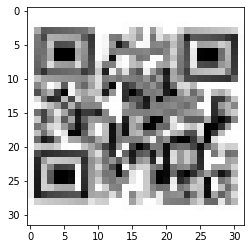

In [ ]:
X1 =  []
Xs1 = []
for features in array:
    X1.append(features)
for features in array_small:
    Xs1.append(features)
X1 = np.array(X1).reshape(-1, 128, 128, 3)
Xs1 = np.array(Xs1).reshape(-1, 32, 32, 3)
plt.imshow(Xs1[0], cmap = 'gray')

In [ ]:
X=np.concatenate((X,X1), axis = 0)
Xs=np.concatenate((Xs,Xs1), axis=0)
X.shape

(20000, 128, 128, 3)

# Training and validation


creating training split

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_valid,y_train, y_valid = train_test_split(Xs, X, test_size = 0.33, random_state = 12)
X_train.shape

(13400, 32, 32, 3)

In [ ]:
from main import *

creating the final generative network

In [ ]:
hr_shape = (y_train.shape[1], y_train.shape[2], y_train.shape[3])
lr_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])

lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)

generator = generator(lr_ip, res_range = 16, upscale_range=2)
generator.summary()

discriminator = discriminator(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
discriminator.summary()

vgg = build_vgg((128,128,3))
print(vgg.summary())
vgg.trainable = False

gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   15616       input_1[0][0]                    
__________________________________________________________________________________________________
p_re_lu (PReLU)                 (None, 32, 32, 64)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 64)   36928       p_re_lu[0][0]                    
______________________________________________________________________________________________

In [ ]:
gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam")
gan_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 128, 128, 3)  2044291     input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
model_1 (Functional)            (None, 1)            38249281    model[0][0]                      
____________________________________________________________________________________________

In [ ]:
batch_size = 1  
train_lr_batches = []
train_hr_batches = []
for it in range(int(y_train.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(y_train[start_idx:end_idx])
    train_lr_batches.append(X_train[start_idx:end_idx])
    

creating training loop for 5 epochs

In [ ]:
epochs = 5
#Enumerate training over epochs
for e in range(epochs):
    
    fake_label = np.zeros((batch_size, 1)) # Assign a label of 0 to all fake (generated images)
    real_label = np.ones((batch_size,1)) # Assign a label of 1 to all real images.
    
    #Create empty lists to populate gen and disc losses. 
    g_losses = []
    d_losses = []
    
    #Enumerate training over batches. 
    for b in tqdm(range(len(train_hr_batches))):
        lr_imgs = train_lr_batches[b] #Fetch a batch of LR images for training
        hr_imgs = train_hr_batches[b] #Fetch a batch of HR images for training
        
        fake_imgs = generator.predict_on_batch(lr_imgs) #Fake images
        
        #First, train the discriminator on fake and real HR images. 
        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)
        
        #Now, train the generator by fixing discriminator as non-trainable
        discriminator.trainable = False
        
        #Average the discriminator loss, just for reporting purposes. 
        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real) 
        
        #Extract VGG features, to be used towards calculating loss
        image_features = vgg.predict(hr_imgs)
     
        #Train the generator via GAN. 
        #Remember that we have 2 losses, adversarial loss and content (VGG) loss
        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])
        
        #Save losses to a list so we can average and report. 
        d_losses.append(d_loss)
        g_losses.append(g_loss)
        
    #Convert the list of losses to an array to make it easy to average    
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)
    
    #Calculate the average losses for generator and discriminator
    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)
    
    #Report the progress during training. 
    print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)

    if (e+1) % 10 == 0: #Change the frequency for model saving, if needed
        #Save the generator after every n epochs (Usually 10 epochs)
        generator.save("gen_e_"+ str(e+1) +".h5")


checking the generator output

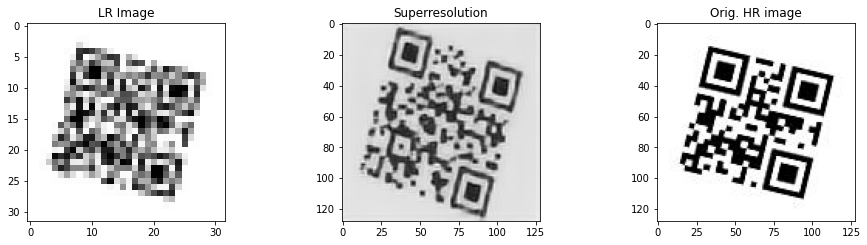

In [ ]:
from keras.models import load_model
from numpy.random import randint

[X1, X2] = [X_valid, y_valid]
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]
gen_image = generator.predict(src_image)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(lri)
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(cv2.cvtColor(gen_image[0,:,:,:], cv2.COLOR_BGR2GRAY),cmap = 'gray')
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(hri)

plt.show()
